In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from tqdm import tqdm
import torch



from Bio import motifs
from Bio.motifs.matrix import PositionWeightMatrix



# ------------------------------
# 2) FILE PATHS
# ------------------------------


Matplotlib is building the font cache; this may take a moment.


In [2]:
sequence_file = "/Users/xiaoyuwang/Desktop/Mini-Hack/test_MPRA.txt"
pwm_file      = "/Users/xiaoyuwang/Desktop/Mini-Hack/JASPAR2024_CORE_vertebrates_non-redundant_pfms_jaspar.txt"

Using Sequence ID=train5, length=295
Loaded 879 motifs from /content/drive/MyDrive/hack/JASPAR2024_CORE_vertebrates_non-redundant_pfms_jaspar.txt.

** Best Motif: Runx1 **
 - Best start  = 133
 - Best center = 137
 - Best score  = 14.51
 - Subsequence: CTGTGGTTT


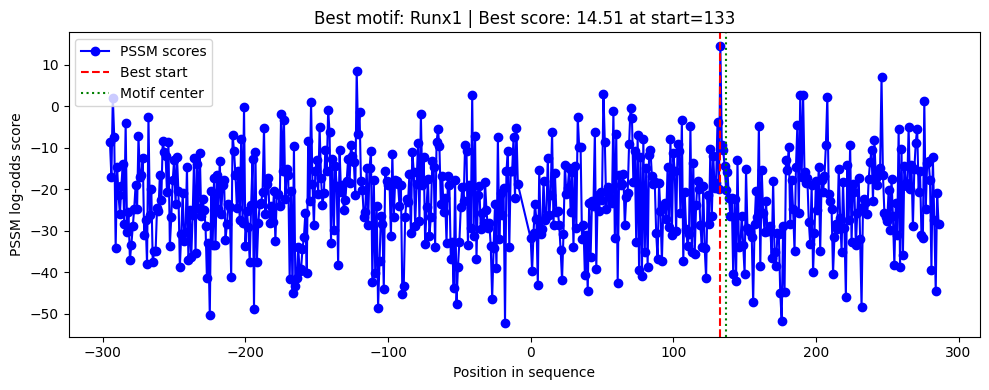

In [5]:
import math
import matplotlib.pyplot as plt
from Bio import motifs

def load_training_data(file_path):
    """
    Example loader that assumes each line of file_path has:
       <sequence_id> <dna_sequence> <295 activity values...>
    We only need the 'sequence' for this demonstration, but you can
    store the ID or the activity scores if needed.
    Returns a list of dictionaries, each with keys: id, sequence, activation_scores.
    """
    training_data = []
    with open(file_path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue  # skip malformed lines

            seq_id = parts[0]
            dna_seq = parts[1]
            # The rest are activation values, if needed:
            if len(parts) > 2:
                act_vals = list(map(float, parts[2:]))
            else:
                act_vals = []

            training_data.append({
                "id": seq_id,
                "sequence": dna_seq,
                "activation_scores": act_vals
            })
    return training_data


def find_peak_pssm_position_for_motif(seq, motif):
    """
    Convert 'motif' to PWM -> PSSM, then use pssm.search(seq, threshold=-9999999)
    to gather *all* positions. Identify the highest-scoring position.

    Returns: (best_start, best_center, best_score, positions_and_scores)
      best_start: index where the motif alignment has max log-odds score
      best_center: best_start + motif.length//2
      best_score: max log-odds score
      positions_and_scores: list of (pos, score) from .search
    If no valid alignment found, returns (None, None, None, []).
    """
    pwm = motif.counts.normalize(pseudocounts=0.1)  # PositionWeightMatrix
    pssm = pwm.log_odds()                           # PositionSpecificScoringMatrix
    motif_len = motif.length

    best_score = float("-inf")
    best_start = None
    positions_and_scores = []

    # .search(...) yields (position, score) for windows >= threshold
    for position, score in pssm.search(seq, threshold=-9999999):
        positions_and_scores.append((position, score))
        if score > best_score:
            best_score = score
            best_start = position

    if best_start is not None:
        best_center = best_start + (motif_len // 2)
        return best_start, best_center, best_score, positions_and_scores
    else:
        return None, None, None, []


def find_best_motif_for_sequence(seq, motifs_list):
    """
    Among all motifs in motifs_list, find the single highest PSSM score
    on 'seq'. Returns (best_motif, best_start, best_center, best_score, pos_scores).
    If no valid windows found for any motif, returns (None, None, None, None, []).
    """
    best_info = {
        "motif": None,
        "start": None,
        "center": None,
        "score": float("-inf"),
        "positions_scores": [],
    }

    for motif in motifs_list:
        start, center, sc, pos_scores = find_peak_pssm_position_for_motif(seq, motif)
        if sc is not None and sc > best_info["score"]:
            best_info["motif"] = motif
            best_info["start"] = start
            best_info["center"] = center
            best_info["score"] = sc
            best_info["positions_scores"] = pos_scores

    if best_info["score"] == float("-inf"):
        return None, None, None, None, []
    else:
        return (best_info["motif"],
                best_info["start"],
                best_info["center"],
                best_info["score"],
                best_info["positions_scores"])


def plot_best_motif_scores(seq, motif, best_start, best_center, best_score, pos_scores):
    """
    Plots the distribution of log-odds scores (pos_scores) for 'motif' across 'seq',
    highlighting the best scoring position (best_start) and approximate center.
    """
    if not pos_scores:
        print("No positions/scores to plot; motif doesn't fit or empty.")
        return

    # Sort positions for a left-to-right plot
    pos_scores.sort(key=lambda x: x[0])
    positions = [ps[0] for ps in pos_scores]
    scores = [ps[1] for ps in pos_scores]

    plt.figure(figsize=(10, 4))
    plt.plot(positions, scores, marker='o', label='PSSM scores', color='blue')

    # Highlight best alignment
    plt.axvline(best_start, color='red', linestyle='--', label='Best start')
    plt.axvline(best_center, color='green', linestyle=':', label='Motif center')

    plt.title(f"Best motif: {motif.name} | Best score: {best_score:.2f} at start={best_start}")
    plt.xlabel("Position in sequence")
    plt.ylabel("PSSM log-odds score")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# EXAMPLE USAGE: combine everything into a main script
# -------------------------------------------------------------------------
if __name__ == "__main__":
    # Path to JASPAR motifs file (multiple motifs)
    jaspar_file = pwm_file

    # Path to your training data file (with IDs, sequences, activity columns, etc.)
    training_file = sequence_file

    # 1) Load the training data
    training_data = load_training_data(training_file)

    if not training_data:
        raise ValueError(f"No data found in {training_file}")

    # Let's pick the FIRST entry's sequence as the 'test_seq'
    test_seq_id = training_data[4]["id"]
    test_seq = training_data[4]["sequence"]

    print(f"Using Sequence ID={test_seq_id}, length={len(test_seq)}")

    # 2) Parse multiple motifs from the JASPAR file
    with open(jaspar_file, "r") as fh:
        motifs_list = motifs.parse(fh, "jaspar")

    print(f"Loaded {len(motifs_list)} motifs from {jaspar_file}.")

    # 3) Find which motif yields the highest PSSM score for this test sequence
    best_motif, best_start, best_center, best_score, pos_scores = find_best_motif_for_sequence(
        test_seq, motifs_list
    )

    # 4) Display & plot results
    if best_motif is not None:
        print(f"\n** Best Motif: {best_motif.name} **")
        print(f" - Best start  = {best_start}")
        print(f" - Best center = {best_center}")
        print(f" - Best score  = {best_score:.2f}")

        best_subseq = test_seq[best_start : best_start + best_motif.length]
        print(f" - Subsequence: {best_subseq}")

        plot_best_motif_scores(
            seq=test_seq,
            motif=best_motif,
            best_start=best_start,
            best_center=best_center,
            best_score=best_score,
            pos_scores=pos_scores,
        )
    else:
        print("No valid alignment found for any motif with this sequence.")

Loaded 879 motifs from /Users/xiaoyuwang/Desktop/Mini-Hack/JASPAR2024_CORE_vertebrates_non-redundant_pfms_jaspar.txt.
Loaded 7720 sequences from /Users/xiaoyuwang/Desktop/Mini-Hack/test_MPRA.txt.
SeqID=test1, Best Motif=TEAD1, Start=186, Center=190, Distance=4, Score=16.30
SeqID=test2, Best Motif=Zic2, Start=180, Center=184, Distance=4, Score=16.34
SeqID=test3, Best Motif=FOXD2, Start=-53, Center=-48, Distance=5, Score=15.93
SeqID=test4, Best Motif=REST, Start=63, Center=73, Distance=10, Score=14.07
SeqID=test5, Best Motif=Hoxa13, Start=9, Center=13, Distance=4, Score=14.53
SeqID=test6, Best Motif=ZNF558, Start=-58, Center=-44, Distance=14, Score=26.78
SeqID=test7, Best Motif=ZNF213, Start=-292, Center=-286, Distance=6, Score=15.86
SeqID=test8, Best Motif=CTCF, Start=-146, Center=-139, Distance=7, Score=17.35
SeqID=test9, Best Motif=ZNF93, Start=-267, Center=-260, Distance=7, Score=19.52
SeqID=test10, Best Motif=ZNF528, Start=-116, Center=-108, Distance=8, Score=16.41
SeqID=test11, Bes

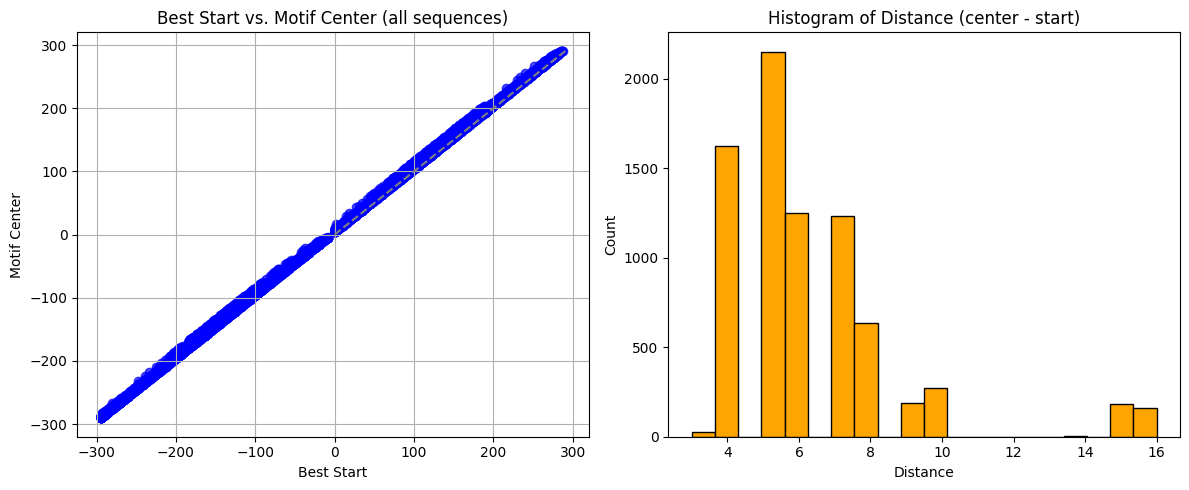

In [4]:
import math
import matplotlib.pyplot as plt
from Bio import motifs

def load_training_data(file_path):
    """
    Example loader that assumes each line of file_path has:
       <sequence_id> <dna_sequence> <some activity values...>
    Returns a list of dictionaries: {id, sequence, activation_scores}.
    (Same as previous examples.)
    """
    training_data = []
    with open(file_path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue  # skip malformed lines

            seq_id = parts[0]
            dna_seq = parts[1]
            # The rest are activation values if needed:
            if len(parts) > 2:
                act_vals = list(map(float, parts[2:]))
            else:
                act_vals = []

            training_data.append({
                "id": seq_id,
                "sequence": dna_seq,
                "activation_scores": act_vals
            })
    return training_data

def find_peak_pssm_position_for_motif(seq, motif):
    """
    Convert 'motif' -> PWM -> PSSM, use pssm.search(seq, threshold=-9999999) to check all positions.
    Returns (best_start, best_center, best_score, positions_and_scores).
    """
    pwm = motif.counts.normalize(pseudocounts=0.1)
    pssm = pwm.log_odds()
    motif_len = motif.length

    best_score = float("-inf")
    best_start = None
    positions_and_scores = []

    for position, score in pssm.search(seq, threshold=-9999999):
        positions_and_scores.append((position, score))
        if score > best_score:
            best_score = score
            best_start = position

    if best_start is not None:
        best_center = best_start + (motif_len // 2)
        return best_start, best_center, best_score, positions_and_scores
    else:
        return None, None, None, []

def find_best_motif_for_sequence(seq, motifs_list):
    """
    Among all motifs in motifs_list, find which motif yields the single highest PSSM score on 'seq'.
    Returns (best_motif, best_start, best_center, best_score, pos_scores).
    If no valid windows found, returns (None, None, None, None, []).
    """
    best_info = {
        "motif": None,
        "start": None,
        "center": None,
        "score": float("-inf"),
        "positions_scores": []
    }

    for motif in motifs_list:
        start, center, sc, pos_scores = find_peak_pssm_position_for_motif(seq, motif)
        if sc is not None and sc > best_info["score"]:
            best_info["motif"] = motif
            best_info["start"] = start
            best_info["center"] = center
            best_info["score"] = sc
            best_info["positions_scores"] = pos_scores

    if best_info["score"] == float("-inf"):
        return None, None, None, None, []
    else:
        return (best_info["motif"],
                best_info["start"],
                best_info["center"],
                best_info["score"],
                best_info["positions_scores"])

def plot_overall_results(results):
    """
    Given a list of dictionaries with:
        {
          'seq_id': <str>,
          'best_motif_name': <str>,
          'best_start': <int>,
          'motif_center': <int>,
          'distance': <int>,
          'best_score': <float>
        }
    Creates two plots:
      1) Scatter of best_start vs. motif_center
      2) Histogram of distance
    """
    # Extract arrays for plotting
    best_starts = [r["best_start"] for r in results]
    centers     = [r["motif_center"] for r in results]
    distances   = [r["distance"] for r in results]

    plt.figure(figsize=(12, 5))

    # 1) Subplot: scatter of best_start vs. motif_center
    plt.subplot(1, 2, 1)
    plt.scatter(best_starts, centers, alpha=0.7, color='blue')
    plt.title("Best Start vs. Motif Center (all sequences)")
    plt.xlabel("Best Start")
    plt.ylabel("Motif Center")
    plt.grid(True)

    # (Optional) diagonal line
    max_val = max(best_starts + centers) if best_starts and centers else 0
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='gray')

    # 2) Subplot: histogram of (center - start)
    plt.subplot(1, 2, 2)
    plt.hist(distances, bins=20, color='orange', edgecolor='black')
    plt.title("Histogram of Distance (center - start)")
    plt.xlabel("Distance")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# EXAMPLE MAIN SCRIPT
# -------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Load multiple JASPAR motifs
    jaspar_file = pwm_file
    with open(jaspar_file, "r") as fh:
        motifs_list = motifs.parse(fh, "jaspar")
    print(f"Loaded {len(motifs_list)} motifs from {jaspar_file}.")

    # 2) Load training data
    training_file = sequence_file
    training_data = load_training_data(training_file)
    print(f"Loaded {len(training_data)} sequences from {training_file}.")

    # 3) For each sequence, find the best motif + alignment
    results = []
    for entry in training_data:
        seq_id = entry["id"]
        seq    = entry["sequence"]

        best_motif, best_start, best_center, best_score, pos_scores = find_best_motif_for_sequence(seq, motifs_list)

        if best_motif is not None:
            distance = best_center - best_start
            results.append({
                "seq_id": seq_id,
                "best_motif_name": best_motif.name,
                "best_start": best_start,
                "motif_center": best_center,
                "distance": distance,
                "best_score": best_score
            })
            # Print per-sequence details if you like:
            print(f"SeqID={seq_id}, Best Motif={best_motif.name}, Start={best_start}, Center={best_center}, Distance={distance}, Score={best_score:.2f}")
        else:
            print(f"SeqID={seq_id}, No valid alignment for any motif.")

    # 4) Plot an overall summary across all sequences
    if results:
        plot_overall_results(results)
    else:
        print("No best results found for any sequence, nothing to plot.")

In [6]:
# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # Adjust these paths as needed


    # Load the training data
    data = load_training_data(sequence_file)
    print(f"Loaded {len(data)} training rows from {pwm_file}.")

    # Print a snippet of the first entry
    # if data:
    #     print("First entry example:")
    #     print("  ID:", data[0]["id"])
    #     print("  Seq (length):", len(data[0]["sequence"]))
    #     print("  Activation Scores (first 5):", data[0]["activation_scores"][:5])

    # Load the JASPAR motifs
    motif_list = load_jaspar_motifs(pwm_file)
    print(f"Loaded {len(motif_list)} motifs from {pwm_file}.")

    # Print the names of the first few motifs
    for i, motif in enumerate(motif_list[:3]):
        print(f"Motif {i+1} name:", motif.name)

    score_motifs_in_sequences(motif_list, data, score_threshold=1000.0)

Loaded 8000 training rows from /content/drive/MyDrive/hack/JASPAR2024_CORE_vertebrates_non-redundant_pfms_jaspar.txt.
Loaded 879 motifs from /content/drive/MyDrive/hack/JASPAR2024_CORE_vertebrates_non-redundant_pfms_jaspar.txt.
Motif 1 name: Arnt
Motif 2 name: PAX6
Motif 3 name: RORA
DNA seq:AGCTCACGGGGACTAGGGCAGGGAGGCTGCGGGGATGGAAAGATCCCAGGCAGCTTCTGCCTCCTTGGAGCCACTATCAGTCTGCAGACCACCAGCCTGCCAAGGTCAAAGTTCACCACTCTCTCCCTGAAATGGATGTTATCCACAAGCTACCGGGCAAGGTCCAGTGTATCAGTGTGGCCTGATCATGTAGCGGCTCTGGTATCGGATTGCCTGGGCTTCAATCTGGCTTATTAGCCGAGTGATCTTGGGCAAGTTACCCGTTGTATTAGTCCCGTTCTCATGTTGCTAATAA
Sequence ID: train1, Min: 0, Min activation score: A, Max: 3, Max Activation score: T
DNA seq:ACTCTCATCCCACAGAATGAGCTTTACAGTAACTTGGATCTCTACACGAAGGTGTAAATTCAGAGCAACTTACCCGATTCTCTGCAACAAAGATGGCAAAGTTTGCAAGGAGTGAAAATCATGTAATACTTCGGGGAAATGCAGGATGCAGCTGCTGCTCCAGCCTGTAAATTGGACTGCACTGACATTCAGTGTTACTGAATGTAACAATCAACTGTTACTGACAAAGCTCGCGAGAGTTGGCAGCAGCAACTTGAAATCTGTTCAGAGGCTAATGGTATAAATGCAATAGTGA
Sequence ID: train2, 

KeyboardInterrupt: 

In [4]:
fh = open(pwm_file)
for m in motifs.parse(fh, "jaspar"):
    print(m)

Streaming output truncated to the last 5000 lines.
C: 280.00  43.00 1842.00   6.00   0.00  12.00   0.00  42.00 295.00
G: 1842.00   0.00   0.00 1842.00   1.00   3.00   0.00   0.00 201.00
T:   2.00 1842.00   0.00   0.00 1842.00 462.00   0.00  17.00 486.00



TF name	HOXC10
Matrix ID	MA0905.2
Matrix:
        0      1      2      3      4      5      6      7      8
A: 1495.00  26.00 315.00 2638.00  27.00 2165.00 3211.00 3211.00 3211.00
C: 1044.00 245.00 3211.00   6.00   0.00   5.00   3.00  76.00 551.00
G: 3211.00   0.00  12.00 3211.00   0.00   4.00   5.00  86.00 532.00
T:  15.00 3211.00 152.00  24.00 3211.00 1047.00 102.00 187.00 1069.00



TF name	HOXC11
Matrix ID	MA0651.3
Matrix:
        0      1      2      3      4      5      6      7      8      9     10
A: 8810.00 4423.00 1308.00  44.00 199.00 540.00   0.00 12177.00 15350.00 15350.00 15350.00
C: 1684.00 777.00 631.00 238.00 15350.00   0.00   0.00   0.00   0.00  22.00 848.00
G: 2098.00 10927.00 14042.00  58.00  20.00 14810.00   0.00